=== SOLUCIÓN ===
x* = (15.000000, 12.000000)   f* = 61.000000

=== Reporte de multiplicadores KKT (si provienen de KKT) ===
Igualdad (y - (x - 13)**2 - 8 = 0): λ ≈ 12.000000
g1: (-x + y + 1 ≤ 0)  → μ1 ≈ 0.000000  (activa: No)
g2: (-x - y + 5 ≤ 0)  → μ2 ≈ 0.000000  (activa: No)
g3: (x - 15 ≤ 0)  → μ3 ≈ 58.000000  (activa: Sí)
g4: (y - 15 ≤ 0)  → μ4 ≈ 0.000000  (activa: No)


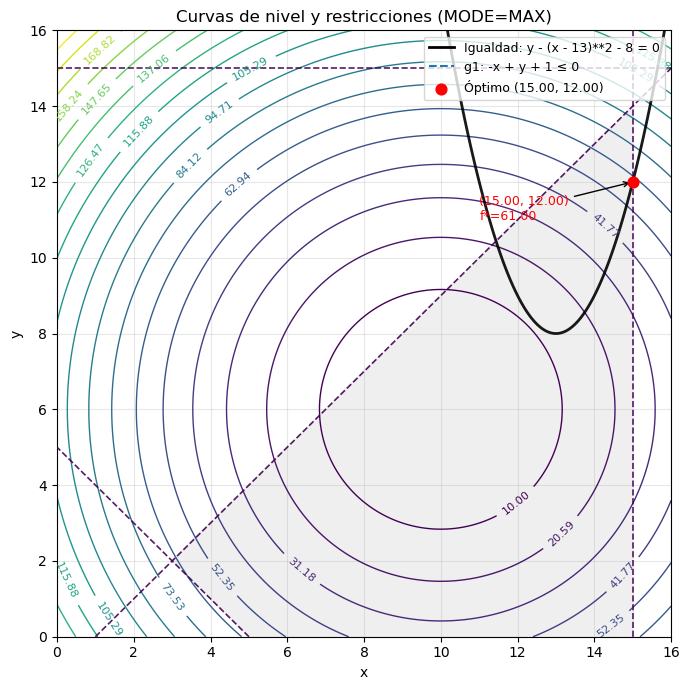

In [1]:
# ============================================================
#  Activo–Inactivo (KKT) con 4 desigualdades y 1 igualdad
#  - Derivadas con SymPy
#  - Modo "max" o "min"
#  - Gráfico con sombreado automático (g_i <= 0)
#  - Semillas robustas (rayos) para h(x,y)=0 de forma arbitraria
#  - Fallback en malla afinado
# ============================================================

import numpy as np
import itertools
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, lambdify, nsolve, Eq

# ============================================================
# (1) CONFIGURACIÓN: define MODO, f_true, {g_i<=0}, h=0
#     * SOLO EDITA AQUÍ *
# ============================================================
MODE = "max"   # "max" para maximizar f_true, "min" para minimizar f_true

# Ventana de ploteo (x_min, x_max, y_min, y_max)
PLOT_WINDOW = (0.0, 16.0, 0.0, 16.0)

# Variables simbólicas
x, y = symbols('x y', real=True)

# --- OBJETIVO NATURAL (f_true): lo que deseas optimizar ---
#   Si MODE="max", internamente minimizaremos -f_true.
#   Este ejemplo es convexo (mínimo en (10,6)); con MODE="max" buscamos
#   el punto factible más lejano a (10,6).
f_true_expr = ((x - 10)**2 + (y - 6)**2)

# --- DESIGUALDADES (g_i <= 0) ---
#   1 - x + y <= 0  equivale a  y <= x - 1
#   5 - x - y <= 0  equivale a  x + y >= 5
#   x - 15 <= 0     equivale a  x <= 15
#   y - 15 <= 0     equivale a  y <= 15
g_exprs = [
    1 - x + y,
    5 - x - y,
    x - 15,
    y - 15,
]

# --- IGUALDAD (h = 0) ---  (puede ser cualquier función suave)
h_expr = -(x-13)**2 -8 +y
#  (x-13)**2 - 5 + (y-11)**2
# ============================================================
# (2) DERIVADAS/GRADIENTES + funciones numéricas
# ============================================================
if MODE.lower() == "max":
    f_expr = -f_true_expr   # minimizaremos -f_true
else:
    f_expr = f_true_expr    # minimizaremos f_true

grad_f  = Matrix([f_expr.diff(x), f_expr.diff(y)])
grads_g = [Matrix([gi.diff(x), gi.diff(y)]) for gi in g_exprs]
grad_h  = Matrix([h_expr.diff(x),  h_expr.diff(y)])

# Lambdify evaluadores
f_prog   = lambdify((x, y), f_expr,     'numpy')   # usado por el programa
f_true   = lambdify((x, y), f_true_expr,'numpy')   # para reporte/gráfico
g_funcs  = [lambdify((x, y), gi, 'numpy') for gi in g_exprs]
h_func   = lambdify((x, y), h_expr,      'numpy')

df   = lambdify((x, y), grad_f,  'numpy')
dg   = [lambdify((x, y), G, 'numpy') for G in grads_g]
dh   = lambdify((x, y), grad_h,  'numpy')

# ============================================================
# (3) Ayudantes: factibilidad y evaluación
# ============================================================
TOL_PRIMAL = 1e-8
TOL_DUAL   = 1e-10

def feasible_xy(xx, yy):
    gvals = np.array([gf(xx, yy) for gf in g_funcs], dtype=float)
    return (np.all(gvals <= TOL_PRIMAL) and abs(h_func(xx, yy)) <= TOL_PRIMAL)

def pack_candidate(xx, yy, lam=0.0, mu_vec=None):
    mu_vec = np.zeros(len(g_exprs)) if mu_vec is None else np.asarray(mu_vec, float)
    return {
        "x": float(xx),
        "y": float(yy),
        "lam": float(lam),
        "mu": np.maximum(mu_vec, 0.0),
        "f_prog": float(f_prog(xx, yy)),
        "f_true": float(f_true(xx, yy)),
        "g_vals": np.array([g(xx, yy) for g in g_funcs], dtype=float),
        "h_val": float(h_func(xx, yy)),
        "active": set([i+1 for i,v in enumerate([g(xx, yy) for g in g_funcs]) if abs(v)<=1e-7])
    }

# ============================================================
# (4) Semillas sobre h=0 por rayos (general para cualquier h)
# ============================================================
def ray_seeds_on_h(num_angles=36, guesses_per_angle=6):
    """
    Dispara rayos desde el centro de f_true (10,6) en muchas direcciones.
    Para cada ángulo resuelve h(cx+t cosθ, cy+t sinθ)=0 con distintos t0.
    Devuelve una lista de puntos (x,y) sobre h=0 (no filtra factibilidad g_i).
    """
    cx, cy = 10.0, 6.0
    # t máximo aproximado para cubrir la ventana
    x_min, x_max, y_min, y_max = PLOT_WINDOW
    max_span = max(x_max - x_min, y_max - y_min)
    t_max = 2.0 * max_span

    seeds = []
    t_guesses = np.linspace(0.0, t_max, guesses_per_angle)[1:]  # evita 0 exacto
    for k in range(num_angles):
        theta = 2.0*np.pi * k / num_angles
        cth, sth = np.cos(theta), np.sin(theta)
        # h(x(t), y(t)) = 0
        t = symbols('t', real=True)
        hx = h_expr.subs({x: cx + t*cth, y: cy + t*sth})
        for t0 in t_guesses:
            try:
                sol_t = float(nsolve(Eq(hx, 0), t, t0, tol=1e-14, maxsteps=100))
            except Exception:
                continue
            xx = cx + sol_t*cth
            yy = cy + sol_t*sth
            # dentro de la ventana para evitar puntos aberrantes
            if (x_min-1e-6) <= xx <= (x_max+1e-6) and (y_min-1e-6) <= yy <= (y_max+1e-6):
                seeds.append((float(xx), float(yy)))

    # deduplicar
    uniq = {}
    for sx, sy in seeds:
        key = (round(sx, 6), round(sy, 6))
        if key not in uniq:
            uniq[key] = (sx, sy)
    return list(uniq.values())

# ============================================================
# (5) Resolver KKT para un conjunto activo
# ============================================================
seed_pool = [
    (0.0, 0.0), (1.0, 1.0), (2.0, 1.0), (10.0, 5.0), (15.0, 7.5),
    (3.0, 1.5), (8.0, 4.0), (12.0, 6.0), (14.0, 7.0), (5.0, 2.5),
    (7.0, 3.5), (11.0, 5.5), (9.0, 5.0), (11.0, 10.5), (7.7, 6.7),
    (11.3, 10.3), (13.0, 12.0), (6.0, 4.0)
]

def intersection_seeds_for_active(active_set):
    """
    Intersecciones numéricas: h=0 y g_i=0 (y opcionalmente otro g_j=0).
    """
    seeds = []
    try:
        from itertools import combinations
        idxs = list(active_set) if active_set else []
        if len(idxs) == 0:
            # Sólo h=0: añade muestras por rayos (general)
            seeds.extend(ray_seeds_on_h())
        elif len(idxs) == 1:
            i = idxs[0]-1
            eqs = [Eq(h_expr, 0), Eq(g_exprs[i], 0)]
            # varios arranques
            for s in seed_pool:
                try:
                    sol = nsolve(eqs, [x, y], s, tol=1e-14, maxsteps=200)
                    seeds.append((float(sol[0]), float(sol[1])))
                except Exception:
                    continue
        else:
            # h=0 con 2 g_i activas
            for i, j in combinations(idxs, 2):
                eqs = [Eq(h_expr, 0), Eq(g_exprs[i-1], 0), Eq(g_exprs[j-1], 0)]
                for s in seed_pool:
                    try:
                        sol = nsolve(eqs, [x, y], s, tol=1e-14, maxsteps=200)
                        seeds.append((float(sol[0]), float(sol[1])))
                    except Exception:
                        continue
    except Exception:
        pass

    # deduplicar
    uniq = {}
    for sx, sy in seeds:
        key = (round(sx, 6), round(sy, 6))
        if key not in uniq:
            uniq[key] = (sx, sy)
    return list(uniq.values())

def try_nsolve_case(active_set):
    from sympy import symbols as sp_symbols

    m = len(g_exprs)
    lam_sym = sp_symbols('lam', real=True)
    mu_syms = [sp_symbols(f'mu{i+1}', real=True) if (i+1) in active_set else None for i in range(m)]
    unknowns = [x, y, lam_sym] + [m for m in mu_syms if m is not None]

    dLx = grad_f[0] + lam_sym*grad_h[0]
    dLy = grad_f[1] + lam_sym*grad_h[1]
    for i in range(m):
        if mu_syms[i] is not None:
            dLx += mu_syms[i]*grads_g[i][0]
            dLy += mu_syms[i]*grads_g[i][1]

    equations = [Eq(dLx, 0), Eq(dLy, 0), Eq(h_expr, 0)]
    for i in range(m):
        if (i+1) in active_set:
            equations.append(Eq(g_exprs[i], 0))

    # Semillas dirigidas: rayos (si no hay g activas) + intersecciones h∩g
    directed = intersection_seeds_for_active(active_set)
    seeds = directed + seed_pool

    for sx, sy in seeds:
        seed_vals = [sx, sy, 0.0]  # x, y, λ
        for i in range(m):
            if mu_syms[i] is not None:
                seed_vals.append(1.0)

        try:
            sol = nsolve(equations, unknowns, seed_vals, tol=1e-14, maxsteps=200, prec=50)
        except Exception:
            continue

        sol = np.array(sol, dtype=float).ravel()
        idx = 0
        x_star = float(sol[idx]); idx += 1
        y_star = float(sol[idx]); idx += 1
        lam    = float(sol[idx]); idx += 1
        mu = np.zeros(m)
        for i in range(m):
            if mu_syms[i] is not None:
                mu[i] = float(sol[idx]); idx += 1

        # Chequeos KKT
        g_vals = np.array([g_funcs[i](x_star, y_star) for i in range(m)], dtype=float)
        h_val  = float(h_func(x_star, y_star))
        primal_ok = (np.all(g_vals <= TOL_PRIMAL) and abs(h_val) <= TOL_PRIMAL)
        if not primal_ok:
            continue

        dual_ok = True
        for i in range(m):
            if (i+1) in active_set and (mu[i] < -TOL_DUAL):
                dual_ok = False; break
        if not dual_ok:
            continue

        df_val = np.array(df(x_star, y_star), dtype=float).ravel()
        dh_val = np.array(dh(x_star, y_star), dtype=float).ravel()
        gradL  = df_val + lam*dh_val
        for i in range(m):
            if (i+1) in active_set:
                grad_i = np.array(dg[i](x_star, y_star), dtype=float).ravel()
                gradL += mu[i]*grad_i

        stat_ok = (np.linalg.norm(gradL, ord=np.inf) <= 1e-6) or (np.linalg.norm(gradL) <= 1e-5)
        if not stat_ok:
            continue

        return pack_candidate(x_star, y_star, lam, mu)

    return None

# ============================================================
# (6) Intersecciones h=0 con g_i=0 para enriquecer candidatos
#     + fallback en malla (banda)
# ============================================================
def all_intersections_candidates():
    cands = []
    m = len(g_exprs)
    # h∩g_i y h∩g_i∩g_j
    for r in [1, 2]:
        for active in itertools.combinations(range(1, m+1), r):
            for s in intersection_seeds_for_active(set(active)):
                if feasible_xy(s[0], s[1]):
                    cands.append(pack_candidate(s[0], s[1]))
    # Sólo h=0 (rayos)
    for s in intersection_seeds_for_active(set()):
        if feasible_xy(s[0], s[1]):
            cands.append(pack_candidate(s[0], s[1]))

    # Deduplicar
    uniq = {}
    for d in cands:
        key = (round(d["x"], 6), round(d["y"], 6))
        if key not in uniq:
            uniq[key] = d
    return list(uniq.values())

def grid_fallback():
    x_min, x_max, y_min, y_max = PLOT_WINDOW
    nx, ny = 1000, 1000  # malla fina
    xg = np.linspace(x_min, x_max, nx)
    yg = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xg, yg)
    H = h_func(X, Y)
    Gm = [gf(X, Y) for gf in g_funcs]
    feas = (np.abs(H) <= 5e-3)  # banda un poco más ancha
    for Gi in Gm:
        feas &= (Gi <= 0.0)
    if not np.any(feas):
        return []
    Z = f_true(X, Y)
    if MODE.lower() == "max":
        idx = np.argmax(np.where(feas, Z, -np.inf))
    else:
        idx = np.argmin(np.where(feas, Z, np.inf))
    iy, ix = np.unravel_index(idx, Z.shape)
    xx, yy = float(X[iy, ix]), float(Y[iy, ix])
    if feasible_xy(xx, yy):
        return [pack_candidate(xx, yy)]
    return []

# ============================================================
# (7) Enumeración de conjuntos activos KKT + candidatos extra
# ============================================================
m = len(g_exprs)
candidates = []

# (a) KKT por activo–inactivo
idxs = list(range(1, m+1))
all_sets = [set(sub) for r in range(0, m+1) for sub in itertools.combinations(idxs, r)]
for active_set in all_sets:
    cand = try_nsolve_case(active_set)
    if cand is not None:
        candidates.append(cand)

# (b) Añadir intersecciones geométricas factibles
candidates.extend(all_intersections_candidates())

# (c) Respaldo en malla
candidates.extend(grid_fallback())

if not candidates:
    print("No se encontró solución factible. Revisa funciones/semillas o condiciones de regularidad.")
    raise SystemExit()

# Elegir según MODE
if MODE.lower() == "max":
    best = max(candidates, key=lambda d: d["f_true"])
else:
    best = min(candidates, key=lambda d: d["f_true"])

# ============================================================
# (8) Salida formateada
# ============================================================
print("=== SOLUCIÓN ===")
print(f"x* = ({best['x']:.6f}, {best['y']:.6f})   f* = {best['f_true']:.6f}\n")

print("=== Reporte de multiplicadores KKT (si provienen de KKT) ===")
print(f"Igualdad ({str(h_expr)} = 0): λ ≈ {best['lam']:.6f}")
for i, gi in enumerate(g_exprs, start=1):
    mui = best["mu"][i-1] if i-1 < len(best["mu"]) else 0.0
    act = abs(best['g_vals'][i-1]) <= 1e-6
    print(f"g{i}: ({str(gi)} ≤ 0)  → μ{i} ≈ {mui:.6f}  (activa: {'Sí' if act else 'No'})")

# ============================================================
# (9) Gráfico (sombreado correcto)
# ============================================================
def plot_problem(best):
    x_min, x_max, y_min, y_max = PLOT_WINDOW
    nx, ny = 400, 400
    xg = np.linspace(x_min, x_max, nx)
    yg = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xg, yg)

    # Curvas de nivel de f_true
    Z = f_true(X, Y)
    zmin, zmax = np.nanmin(Z), np.nanmax(Z)
    lo = zmin + 0.05*(zmax - zmin)
    hi = zmin + 0.95*(zmax - zmin)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = zmin, zmax
    levels = np.linspace(lo, hi, 18)

    fig, ax = plt.subplots(figsize=(7, 7))
    cs = ax.contour(X, Y, Z, levels=levels, linewidths=1.0)
    ax.clabel(cs, inline=True, fontsize=8, fmt="%.2f")

    # Igualdad h=0
    H = h_func(X, Y)
    ax.contour(X, Y, H, levels=[0.0], linewidths=2.0, linestyles='solid', alpha=0.9, colors='k', zorder=3)
    ax.plot([], [], color='k', lw=2.0, label=f"Igualdad: {str(h_expr)} = 0")

    # Desigualdades g_i <= 0 + sombreado
    masks = []
    for i, gi_fun in enumerate(g_funcs, start=1):
        Gi = gi_fun(X, Y)
        ax.contour(X, Y, Gi, levels=[0.0], linewidths=1.2, linestyles='--', alpha=0.9, zorder=3)
        ax.plot([], [], ls='--', color='C0',
                label=f"g{i}: {str(g_exprs[i-1])} ≤ 0" if i == 1 else None)
        masks.append(Gi <= 0.0)

    feas_mask = np.logical_and.reduce(masks)
    feas_int = feas_mask.astype(int)
    ax.contourf(X, Y, feas_int, levels=[0.5, 1.5], alpha=0.15, cmap='Greys', zorder=1)

    # Óptimo
    ax.scatter([best['x']], [best['y']], c='red', s=60, zorder=5,
               label=f"Óptimo ({best['x']:.2f}, {best['y']:.2f})")
    ax.annotate(f"({best['x']:.2f}, {best['y']:.2f})\nf*={best['f_true']:.2f}",
                xy=(best['x'], best['y']), xytext=(best['x']-4, best['y']-1),
                arrowprops=dict(arrowstyle='->', lw=1.0), fontsize=9, color='red')

    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"Curvas de nivel y restricciones (MODE={MODE.upper()})")

    # Leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    seen = set(); handles2, labels2 = [], []
    for h_, l_ in zip(handles, labels):
        if l_ and l_ not in seen:
            handles2.append(h_); labels2.append(l_); seen.add(l_)
    if handles2:
        ax.legend(handles2, labels2, loc="upper right", fontsize=9)

    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_problem(best)


=== SOLUCIÓN (solo desigualdades) ===
x* = (9.752332, 6.070668)   f* = 0.066333
Origen del candidato: KKT active={2}
g1: (y + (x - 8)**2 - 12 ≤ 0) → valor = -2.859e+00  | μ1≈0.000000  | activa: No
g2: (-y + (x - 8)**2 + 3 ≤ 0) → valor = +4.885e-15  | μ2≈0.141336  | activa: Sí


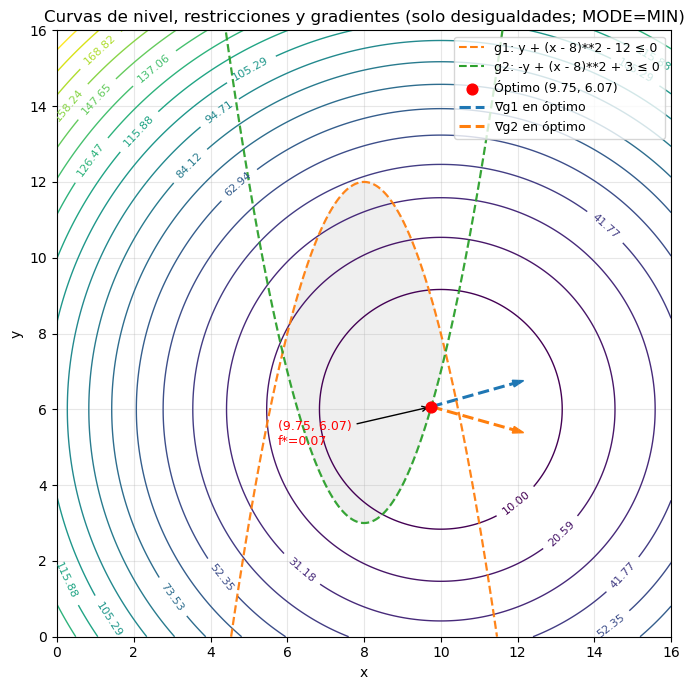

In [2]:
# ============================================================
#  KKT con SOLO DESIGUALDADES (2) y SIN igualdad
#  - Derivadas con SymPy
#  - Modo "max" o "min"
#  - Sombreado automático (g_i <= 0)
#  - Elección robusta del óptimo (activo–inactivo + vértices + malla)
#  - Gradientes de las restricciones (segmentados y colores distintos)
# ============================================================

import numpy as np
import itertools
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, lambdify, nsolve, Eq, solveset, S

# ============================================================
# (1) CONFIGURACIÓN: MODO, f_true, {g_i<=0} (exactamente dos)
# ============================================================
MODE = "min"   # "max" para maximizar f_true, "min" para minimizar f_true

# Ventana de ploteo (x_min, x_max, y_min, y_max)
PLOT_WINDOW = (0.0, 16.0, 0.0, 16.0)

# Variables simbólicas
x, y = symbols('x y', real=True)

# --- OBJETIVO NATURAL (f_true) ---
#   Si MODE="max", internamente minimizaremos -f_true.
#   Nota: este ejemplo tiene mínimo en (10,6); con MAX se busca el punto factible
#   más lejano a (10,6) dentro de la región factible (solo desigualdades).
f_true_expr = ((x - 10)**2 + (y - 6)**2)

# --- DESIGUALDADES (g_i <= 0) ---
#   1) 1 - x + y <= 0  <=>  y <= x - 1
#   2) 5 - x - y <= 0  <=>  x + y >= 5
#   Cambia aquí si quieres otras.
g_exprs = [
    -(12 - (x-8)**2) + y,
    +3 +(x-8)**2 -y,
]
#    6 - x - y,
#   -14 +x  + y,

# ============================================================
# (2) DERIVADAS/GRADIENTES + funciones numéricas
# ============================================================
# Convertimos el objetivo según MODE
if MODE.lower() == "max":
    f_expr = -f_true_expr   # minimizaremos -f_true
else:
    f_expr = f_true_expr    # minimizaremos f_true

# Gradientes simbólicos
grad_f  = Matrix([f_expr.diff(x), f_expr.diff(y)])
grads_g = [Matrix([gi.diff(x), gi.diff(y)]) for gi in g_exprs]

# Lambdify evaluadores
f_prog   = lambdify((x, y), f_expr,     'numpy')   # usado por el programa
f_true   = lambdify((x, y), f_true_expr,'numpy')   # para reporte/gráfico
g_funcs  = [lambdify((x, y), gi, 'numpy') for gi in g_exprs]

df   = lambdify((x, y), grad_f,  'numpy')
dg   = [lambdify((x, y), G, 'numpy') for G in grads_g]

# ============================================================
# (3) Ayudantes: factibilidad y evaluación
# ============================================================
TOL_PRIMAL = 1e-8
TOL_DUAL   = 1e-10

def feasible_xy(xx, yy):
    gvals = np.array([gf(xx, yy) for gf in g_funcs], dtype=float)
    return np.all(gvals <= TOL_PRIMAL)

def pack_candidate(xx, yy, mu_vec=None, source=""):
    mu_vec = np.zeros(len(g_exprs)) if mu_vec is None else np.asarray(mu_vec, float)
    return {
        "x": float(xx),
        "y": float(yy),
        "mu": np.maximum(mu_vec, 0.0),
        "f_prog": float(f_prog(xx, yy)),
        "f_true": float(f_true(xx, yy)),
        "g_vals": np.array([g(xx, yy) for g in g_funcs], dtype=float),
        "active": set([i+1 for i,v in enumerate([g(xx, yy) for g in g_funcs]) if abs(v)<=1e-7]),
        "source": source
    }

# ============================================================
# (4) Resolver KKT para un conjunto activo (SOLO desigualdades)
#     Estacionariedad: ∇f + Σ μ_i ∇g_i = 0   con μ_i≥0
#     Complementariedad: μ_i g_i = 0 (impuesta vía g_i=0 para activas)
# ============================================================
seed_pool = [
    (0.0, 0.0), (1.0, 1.0), (2.0, 1.0), (10.0, 5.0), (15.0, 7.5),
    (3.0, 1.5), (8.0, 4.0), (12.0, 6.0), (14.0, 7.0), (5.0, 2.5),
    (7.0, 3.5), (11.0, 5.0), (11.0, 10.5), (7.7, 6.7), (11.3, 10.3),
]

def try_nsolve_case(active_set):
    from sympy import symbols as sp_symbols

    m = len(g_exprs)
    # μ_i solo para activas
    mu_syms = [sp_symbols(f'mu{i+1}', real=True) if (i+1) in active_set else None for i in range(m)]
    unknowns = [x, y] + [m for m in mu_syms if m is not None]

    # Estacionariedad
    dLx = grad_f[0]
    dLy = grad_f[1]
    for i in range(m):
        if mu_syms[i] is not None:
            dLx += mu_syms[i]*grads_g[i][0]
            dLy += mu_syms[i]*grads_g[i][1]

    equations = [Eq(dLx, 0), Eq(dLy, 0)]
    # g_i activas => g_i = 0
    for i in range(m):
        if (i+1) in active_set:
            equations.append(Eq(g_exprs[i], 0))

    # Semillas: intersecciones de bordes del conjunto activo + pool general
    directed = intersection_seeds_for_active(active_set)
    seeds = directed + seed_pool

    for sx, sy in seeds:
        seed_vals = [sx, sy]
        for i in range(m):
            if mu_syms[i] is not None:
                seed_vals.append(1.0)

        try:
            sol = nsolve(equations, unknowns, seed_vals, tol=1e-14, maxsteps=200, prec=50)
        except Exception:
            continue

        sol = np.array(sol, dtype=float).ravel()
        idx = 0
        x_star = float(sol[idx]); idx += 1
        y_star = float(sol[idx]); idx += 1
        mu = np.zeros(m)
        for i in range(m):
            if mu_syms[i] is not None:
                mu[i] = float(sol[idx]); idx += 1

        # Chequeos KKT
        g_vals = np.array([g_funcs[i](x_star, y_star) for i in range(m)], dtype=float)
        primal_ok = np.all(g_vals <= TOL_PRIMAL)
        if not primal_ok:
            continue

        # μ_i >= 0 para activas
        dual_ok = True
        for i in range(m):
            if (i+1) in active_set and (mu[i] < -TOL_DUAL):
                dual_ok = False; break
        if not dual_ok:
            continue

        # Estacionariedad numérica
        df_val = np.array(df(x_star, y_star), dtype=float).ravel()
        gradL  = df_val.copy()
        for i in range(m):
            if (i+1) in active_set:
                grad_i = np.array(dg[i](x_star, y_star), dtype=float).ravel()
                gradL += mu[i]*grad_i

        stat_ok = (np.linalg.norm(gradL, ord=np.inf) <= 1e-6) or (np.linalg.norm(gradL) <= 1e-5)
        if not stat_ok:
            continue

        return pack_candidate(x_star, y_star, mu, source=f"KKT active={active_set}")

    return None

# ============================================================
# (5) Intersecciones g_i=0 para enriquecer candidatos
# ============================================================
def intersection_seeds_for_active(active_set):
    """Puntos guía: intersecciones de las g_i=0 del conjunto activo."""
    seeds = []
    try:
        active_idx = list(active_set)
        if len(active_idx) == 1:
            # Tomamos puntos de esa recta/línea usando solveset con un parámetro
            i = active_idx[0]-1
            gi = g_exprs[i]
            # Elegimos dos puntos de referencia sobre la línea g_i=0 dentro de la ventana
            # muestreamos x y resolvemos y (o viceversa) si es lineal simple
            # aquí no añadimos nada específico; confiamos en seed_pool
            pass
        elif len(active_idx) >= 2:
            for (i, j) in itertools.combinations(active_idx, 2):
                gi = g_exprs[i-1]; gj = g_exprs[j-1]
                try:
                    sol = nsolve([Eq(gi, 0), Eq(gj, 0)], [x, y], (10.0, 6.0), tol=1e-14, maxsteps=200)
                    seeds.append((float(sol[0]), float(sol[1])))
                except Exception:
                    # Intento alterno con solveset cuando sea posible (lineales típicamente)
                    try:
                        SS = solveset(Eq(gi, 0) & Eq(gj, 0), (x, y), domain=S.Reals)
                        for s in getattr(SS, 'args', []):
                            if len(s) == 2 and all(v.is_real for v in s):
                                seeds.append((float(s[0]), float(s[1])))
                    except Exception:
                        pass
    except Exception:
        pass
    return seeds

def all_boundary_vertices():
    """Devuelve intersecciones de TODOS los pares g_i=0 factibles (vértices)."""
    cands = []
    m = len(g_exprs)
    for i in range(m):
        for j in range(i+1, m):
            try:
                sol = nsolve([Eq(g_exprs[i], 0), Eq(g_exprs[j], 0)], [x, y], (10.0, 6.0), tol=1e-14, maxsteps=200)
                sx, sy = float(sol[0]), float(sol[1])
                if feasible_xy(sx, sy):
                    cands.append(pack_candidate(sx, sy, source="vertex nsolve"))
            except Exception:
                try:
                    SS = solveset(Eq(g_exprs[i], 0) & Eq(g_exprs[j], 0), (x, y), domain=S.Reals)
                    for s in getattr(SS, 'args', []):
                        if len(s) == 2 and all(v.is_real for v in s):
                            sx, sy = float(s[0]), float(s[1])
                            if feasible_xy(sx, sy):
                                cands.append(pack_candidate(sx, sy, source="vertex solveset"))
                except Exception:
                    continue
    # Deduplicar
    uniq = {}
    for d in cands:
        key = (round(d["x"], 6), round(d["y"], 6))
        if key not in uniq:
            uniq[key] = d
    return list(uniq.values())

# ============================================================
# (6) Enumeración de conjuntos activos + vértices + respaldo malla
# ============================================================
m = len(g_exprs)
candidates = []

# (a) KKT por activo–inactivo (incluye caso interior: active_set vacío)
idxs = list(range(1, m+1))
all_sets = [set(sub) for r in range(0, m+1) for sub in itertools.combinations(idxs, r)]
for active_set in all_sets:
    cand = try_nsolve_case(active_set)
    if cand is not None:
        candidates.append(cand)

# (b) Añadir vértices del polígono/curvas (intersecciones g_i=0)
candidates.extend(all_boundary_vertices())

# (c) Respaldo: búsqueda en malla dentro de g_i<=0
def grid_fallback():
    x_min, x_max, y_min, y_max = PLOT_WINDOW
    nx, ny = 600, 600
    xg = np.linspace(x_min, x_max, nx)
    yg = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xg, yg)
    Gm = [gf(X, Y) for gf in g_funcs]
    feas = np.ones_like(X, dtype=bool)
    for Gi in Gm:
        feas &= (Gi <= 0.0)
    if not np.any(feas):
        return []
    Z = f_true(X, Y)
    if MODE.lower() == "max":
        idx = np.argmax(np.where(feas, Z, -np.inf))
    else:
        idx = np.argmin(np.where(feas, Z, np.inf))
    iy, ix = np.unravel_index(idx, Z.shape)
    xx, yy = float(X[iy, ix]), float(Y[iy, ix])
    if feasible_xy(xx, yy):
        return [pack_candidate(xx, yy, source="grid")]
    return []

candidates.extend(grid_fallback())

if not candidates:
    print("No se encontró solución factible. Revisa funciones/semillas o condiciones de regularidad.")
    raise SystemExit()

# Elegir según MODE
if MODE.lower() == "max":
    best = max(candidates, key=lambda d: d["f_true"])
else:
    best = min(candidates, key=lambda d: d["f_true"])

# ============================================================
# (7) Salida formateada
# ============================================================
print("=== SOLUCIÓN (solo desigualdades) ===")
print(f"x* = ({best['x']:.6f}, {best['y']:.6f})   f* = {best['f_true']:.6f}")
print(f"Origen del candidato: {best['source']}")
for i, gi in enumerate(g_exprs, start=1):
    act = abs(best['g_vals'][i-1]) <= 1e-6
    mui = best["mu"][i-1] if i-1 < len(best["mu"]) else 0.0
    print(f"g{i}: ({str(gi)} ≤ 0) → valor = {best['g_vals'][i-1]:+.3e}  | μ{i}≈{mui:.6f}  | activa: {'Sí' if act else 'No'}")

# ============================================================
# (8) Gráfico + gradientes de las restricciones (segmentados y colores)
# ============================================================
def plot_problem(best):
    x_min, x_max, y_min, y_max = PLOT_WINDOW
    nx, ny = 400, 400
    xg = np.linspace(x_min, x_max, nx)
    yg = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xg, yg)

    # Curvas de nivel de f_true
    Z = f_true(X, Y)
    zmin, zmax = np.nanmin(Z), np.nanmax(Z)
    lo = zmin + 0.05*(zmax - zmin)
    hi = zmin + 0.95*(zmax - zmin)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = zmin, zmax
    levels = np.linspace(lo, hi, 18)

    fig, ax = plt.subplots(figsize=(7, 7))
    cs = ax.contour(X, Y, Z, levels=levels, linewidths=1.0)
    ax.clabel(cs, inline=True, fontsize=8, fmt="%.2f")

    # Desigualdades g_i <= 0 + sombreado
    masks = []
    for i, gi_fun in enumerate(g_funcs, start=1):
        Gi = gi_fun(X, Y)
        ax.contour(X, Y, Gi, levels=[0.0], linewidths=1.6, linestyles='--', alpha=0.95, zorder=3, colors=[f"C{i}"])
        ax.plot([], [], ls='--', color=f"C{i}", label=f"g{i}: {str(g_exprs[i-1])} ≤ 0")
        masks.append(Gi <= 0.0)

    feas_mask = np.logical_and.reduce(masks)
    feas_int = feas_mask.astype(int)
    ax.contourf(X, Y, feas_int, levels=[0.5, 1.5], alpha=0.15, cmap='Greys', zorder=1)

    # Óptimo
    ax.scatter([best['x']], [best['y']], c='red', s=60, zorder=5,
               label=f"Óptimo ({best['x']:.2f}, {best['y']:.2f})")
    ax.annotate(f"({best['x']:.2f}, {best['y']:.2f})\nf*={best['f_true']:.2f}",
                xy=(best['x'], best['y']), xytext=(best['x']-4, best['y']-1),
                arrowprops=dict(arrowstyle='->', lw=1.0), fontsize=9, color='red')

    # ===== Gradientes de las 2 restricciones en el óptimo =====
    L = 2.5  # longitud base de los segmentos
    colors = ["tab:blue", "tab:orange"]  # dos colores distintos
    for i in range(len(g_exprs)):
        grad_i = np.array(dg[i](best['x'], best['y']), dtype=float).ravel()
        norm = np.linalg.norm(grad_i)
        if norm < 1e-12:
            continue
        v = (L / norm) * grad_i
        # Segmento discontinuo desde el óptimo hacia la dirección del gradiente
        ax.plot([best['x'], best['x'] + v[0]], [best['y'], best['y'] + v[1]],
                linestyle='--', linewidth=2.2, color=colors[i],
                label=f"∇g{i+1} en óptimo")
        # pequeña cabeza de flecha para dirección
        ax.arrow(best['x'] + v[0]*0.9, best['y'] + v[1]*0.9, v[0]*0.1, v[1]*0.1,
                 head_width=0.18, head_length=0.28, fc=colors[i], ec=colors[i],
                 length_includes_head=True)

    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"Curvas de nivel, restricciones y gradientes (solo desigualdades; MODE={MODE.upper()})")

    # Leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    seen = set(); handles2, labels2 = [], []
    for h_, l_ in zip(handles, labels):
        if l_ and l_ not in seen:
            handles2.append(h_); labels2.append(l_); seen.add(l_)
    if handles2:
        ax.legend(handles2, labels2, loc="upper right", fontsize=9)

    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_problem(best)


In [3]:
# ============================================================
#  KKT interactivo con slider del centro (x) de la elipse derecha
#  - μ_i ∇g_i con una escala
#  - Paralelogramo y −∇f con otra escala
#  - Slider: mueve el centro en x de la restricción derecha
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, lambdify, nsolve, Eq
import ipywidgets as widgets
from ipywidgets import interact

# ---------- Configuración base ----------
x, y = symbols('x y', real=True)
MODE = "min"
PLOT_WINDOW = (4.0, 16.0, 3.0, 10.5)

# Objetivo (mínimo no restringido cerca de (10, 7.8))
f_true_expr = (x - 10)**2 + (y - 7.8)**2

# Elipse izquierda fija (interior factible)
g1 = (x - 8)**2/9 + (y - 6)**2/4 - 1

# Derivadas simbólicas
grad_f = Matrix([f_true_expr.diff(x), f_true_expr.diff(y)])
grad_g1 = Matrix([g1.diff(x), g1.diff(y)])

# Funciones numéricas f, ∇f, ∇g1
f_true = lambdify((x, y), f_true_expr, 'numpy')
df = lambdify((x, y), grad_f, 'numpy')
dg1 = lambdify((x, y), grad_g1, 'numpy')
g1f = lambdify((x, y), g1, 'numpy')

def solve_and_plot(cx):
    """
    cx: centro en x de la elipse derecha (y-centro fijo en 6).
    """
    # --- Definir g2 (elipse derecha) con centro variable cx ---
    g2 = (x - cx)**2/9 + (y - 6)**2/4 - 1
    grad_g2 = Matrix([g2.diff(x), g2.diff(y)])
    dg2 = lambdify((x, y), grad_g2, 'numpy')
    g2f = lambdify((x, y), g2, 'numpy')

    # --- Resolver intersección g1=0 & g2=0 (punto superior si existe) ---
    xs, ys = None, None
    for guess in [(cx, 7.5), (10.0, 7.5), (cx, 8.0), (10.0, 8.0)]:  # varios tries
        try:
            sol = nsolve([Eq(g1, 0), Eq(g2, 0)], [x, y], guess, tol=1e-14, maxsteps=200)
            xs, ys = float(sol[0]), float(sol[1])
            break
        except Exception:
            continue

    # Si falló el punto superior, intenta el inferior
    if xs is None:
        for guess in [(cx, 4.5), (10.0, 4.5), (cx, 5.0), (10.0, 5.0)]:
            try:
                sol = nsolve([Eq(g1, 0), Eq(g2, 0)], [x, y], guess, tol=1e-14, maxsteps=200)
                xs, ys = float(sol[0]), float(sol[1])
                break
            except Exception:
                continue

    # Preparar figura
    x_min, x_max, y_min, y_max = PLOT_WINDOW
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 400),
                       np.linspace(y_min, y_max, 400))
    Z = f_true(X, Y)
    fig, ax = plt.subplots(figsize=(7,7))
    cs = ax.contour(X, Y, Z, levels=20, linewidths=1.0)
    ax.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

    # Bordes de las elipses y sombreado factible
    G1 = g1f(X, Y)
    G2 = g2f(X, Y)
    ax.contour(X, Y, G1, [0], colors='tab:blue',   linestyles='--', linewidths=1.6, label='g1=0')
    ax.contour(X, Y, G2, [0], colors='tab:orange', linestyles='--', linewidths=1.6, label='g2=0')
    mask = (G1<=0) & (G2<=0)
    ax.contourf(X, Y, mask.astype(int), levels=[0.5,1.5], cmap='Greys', alpha=0.15)

    if xs is None:
        ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.set_title(f"No hay intersección numérica para g2 centrada en x={cx:.2f}")
        ax.grid(alpha=0.3)
        plt.show()
        return

    # Punto óptimo (intersección)
    ax.scatter(xs, ys, color='red', s=60, label='Óptimo')

    # --- Gradientes y multiplicadores KKT (G μ = −∇f) ---
    gradf = np.array(df(xs, ys), float).ravel()
    gradg1 = np.array(dg1(xs, ys), float).ravel()
    gradg2 = np.array(dg2(xs, ys), float).ravel()
    G = np.column_stack([gradg1, gradg2])
    mu_sol, *_ = np.linalg.lstsq(G, -gradf, rcond=None)
    mu1, mu2 = mu_sol

    # Vectores
    vec1 = mu1 * gradg1
    vec2 = mu2 * gradg2
    vec_sum = vec1 + vec2
    neg_gradf = -gradf

    # --- Escalas distintas ---
    # Flechas de μ_i ∇g_i
    max_len_vecs = np.max(np.linalg.norm(np.vstack([vec1, vec2]), axis=1))
    scale_vec = 2.0 / max_len_vecs if max_len_vecs > 1e-12 else 1.0
    # Paralelogramo y −∇f
    max_len_para = np.linalg.norm(vec_sum)
    scale_para = 3.0 / max_len_para if max_len_para > 1e-12 else 1.0

    def arrow(base, v, color, label, hw=0.14, hl=0.22, lw=2.0):
        ax.arrow(base[0], base[1], v[0], v[1],
                 head_width=hw, head_length=hl,
                 fc=color, ec=color, lw=lw, length_includes_head=True,
                 label=label, zorder=5)

    # Flechas μ_i ∇g_i con escala_vec
    arrow((xs, ys), vec1*scale_vec, 'tab:blue',  r'$\mu_1\nabla g_1$')
    arrow((xs, ys), vec2*scale_vec, 'tab:orange', r'$\mu_2\nabla g_2$')

    # Paralelogramo con escala_para
    p0 = np.array([xs, ys])
    p1 = p0 + vec1*scale_para
    p2 = p0 + vec2*scale_para
    p3 = p1 + (p2 - p0)
    ax.plot([p0[0], p1[0], p3[0], p2[0], p0[0]],
            [p0[1], p1[1], p3[1], p2[1], p0[1]],
            color='purple', lw=2.0, label='Paralelogramo (escala distinta)')

    # Diagonal (suma) y -∇f con MISMA escala_para para que coincidan
    arrow(p0, vec_sum*scale_para, 'purple', r'$\sum \mu_i\nabla g_i$', hw=0.12, hl=0.18, lw=2.2)
    arrow(p0, neg_gradf*scale_para, 'black', r'$-\nabla f(x^*)$', hw=0.12, hl=0.18, lw=2.2)

    # Texto con μ y residuo
    resid = np.linalg.norm(gradf + mu1*gradg1 + mu2*gradg2)
    ax.text(x_min+0.2, y_max-0.5, fr'$\mu_1={mu1:.3f},\ \mu_2={mu2:.3f},\ \|\text{{res}}\|={resid:.2e}$',
            fontsize=9, color='black')

    # Estética
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"Centro g2 en x={cx:.2f}  —  KKT con paralelogramo")
    ax.legend(fontsize=9, loc="upper right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------- Slider: centro en x de la elipse derecha ----------
interact(solve_and_plot,
         cx=widgets.FloatSlider(value=12.0, min=9.0, max=14.5, step=0.1,
                                description='centro g2 (x):', readout_format='.1f'));


interactive(children=(FloatSlider(value=12.0, description='centro g2 (x):', max=14.5, min=9.0, readout_format=…